In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers.python.layers import layers
import pickle
import os
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [5]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [6]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [7]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [8]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [9]:
######################

In [10]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [11]:
dictionary = make_dictionary(all_codones)

In [12]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [13]:
######################

In [16]:
class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver() 

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        with tf.name_scope("embed"):
            embed_matrix = tf.Variable(tf.truncated_normal([self.vocab_size, 2000], stddev=1.0 / (2000 ** 0.5)), trainable=True)
            embed = tf.nn.embedding_lookup(embed_matrix, self.center_words, name='embed')    
            self.weights1 = tf.Variable(tf.truncated_normal([2000, 900], stddev=1.0 / (self.embed_size ** 0.5)), trainable=True)
            self.baises1 = tf.Variable(tf.zeros([900]), trainable=True)
            self.weights2 = tf.Variable(tf.truncated_normal([900, self.embed_size], stddev=1.0 / (900 ** 0.5)), trainable=True, dtype=tf.float32)
            self.baises2 = tf.Variable(tf.zeros([self.embed_size]), trainable=True, dtype=tf.float32)
            self.layer = tf.matmul(tf.nn.tanh(tf.matmul(embed, self.weights1) + self.baises1), self.weights2) + self.baises2
            
    def _create_loss(self):
        with tf.device('/cpu:0'):
            with tf.name_scope("loss"):
                self._create_embedding()
                # construct variables for NCE loss
                nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                             stddev=1.0 / (self.embed_size ** 0.5)),
                                         name='nce_weight')
                nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

                # define loss function to be NCE loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                          biases=nce_bias,
                                                          labels=self.target_words,
                                                          inputs=self.layer,
                                                          num_sampled=self.num_sampled,
                                                          num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.AdagradOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()
    def get_embed(self):
        self.encode = tf.matmul(tf.nn.tanh(tf.matmul(self.embed_matrix, self.weights1) + self.baises1), self.weights2) + self.baises2
        return self.encode

    def build_graph(self):
        """ Build the graph for our model """
        
        self._create_placeholders()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [17]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .9
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

In [18]:
######################

In [21]:
f = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)
print("f")

Average loss at step 1999:  49.4
Average loss at step 3999:  26.5
Average loss at step 5999:  17.8
Average loss at step 7999:  17.0
Average loss at step 9999:  11.3
Average loss at step 11999:  12.4
Average loss at step 13999:   8.3
Average loss at step 15999:  12.3
Average loss at step 17999:   9.9
Average loss at step 19999:   9.4
Average loss at step 21999:   9.0
Average loss at step 23999:   7.8
Average loss at step 25999:   7.2
Average loss at step 27999:   7.0
Average loss at step 29999:   6.4
Average loss at step 31999:   6.8
Average loss at step 33999:   6.4
Average loss at step 35999:   4.4
Average loss at step 37999:   5.9
Average loss at step 39999:   5.6
Average loss at step 41999:   5.3
Average loss at step 43999:   5.4
Average loss at step 45999:   4.4
Average loss at step 47999:   4.9
Average loss at step 49999:   4.8
Average loss at step 51999:   3.6
Average loss at step 53999:   3.4
Average loss at step 55999:   2.9
Average loss at step 57999:   4.1
Average loss at ste

In [20]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [19]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op], feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        #final_embed_matrix = sess.run(model._create_embedding(model.embed_matrix))
        final_embed_matrix = sess.run([model.test_embed()], feed_dict)
        return final_embed_matrix

In [42]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999: 65887.8
Average loss at step 3999: 404.9
Average loss at step 5999: 219.4
Average loss at step 7999: 134.1
Average loss at step 9999:  95.3
Average loss at step 11999:  77.0
Average loss at step 13999:  58.2
Average loss at step 15999:  40.2
Average loss at step 17999:  39.1
Average loss at step 19999:  29.1
Average loss at step 21999:  27.9
Average loss at step 23999:  24.0
Average loss at step 25999:  22.6
Average loss at step 27999:  26.5
Average loss at step 29999:  29.3
Average loss at step 31999:  29.8
Average loss at step 33999:  26.6
Average loss at step 35999:  24.6
Average loss at step 37999:  22.7
Average loss at step 39999:  18.2
Average loss at step 41999:  14.6
Average loss at step 43999:  15.1
Average loss at step 45999:  26.0
Average loss at step 47999:  23.2
Average loss at step 49999:  18.7
Average loss at step 51999:  16.4
Average loss at step 53999:  15.1
Average loss at step 55999:  19.5
Average loss at step 57999:  21.0
Average loss at s

In [22]:
######################
print('1')

1


In [24]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [25]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0         x1 codone
0   8.836071   5.444793    SAS
1  31.622574  26.763624    KKG
2 -14.207759 -56.471107    LAD
3 -14.742878 -58.445450    RIY
4 -24.916101 -69.975662    AHC

In [26]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

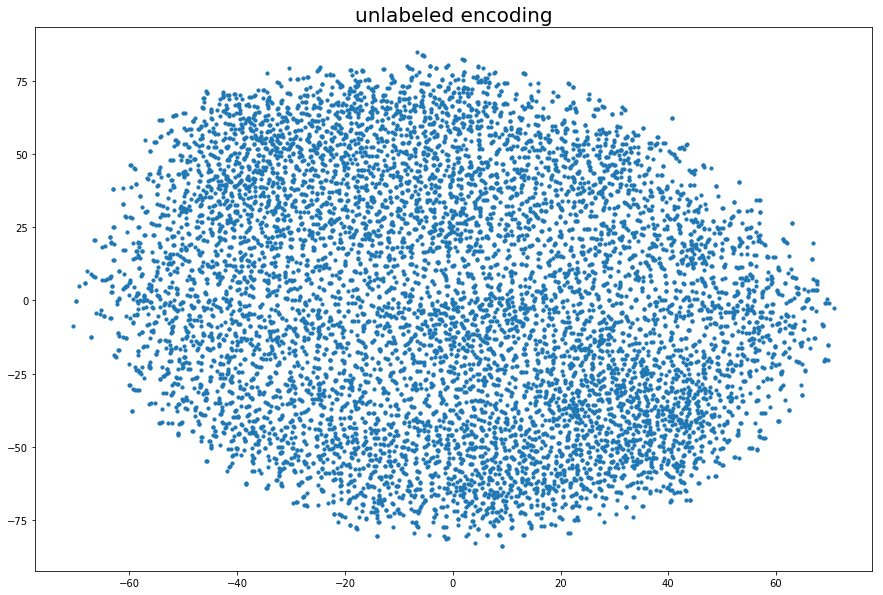

In [27]:
plot_tsne_df(tsne_df)

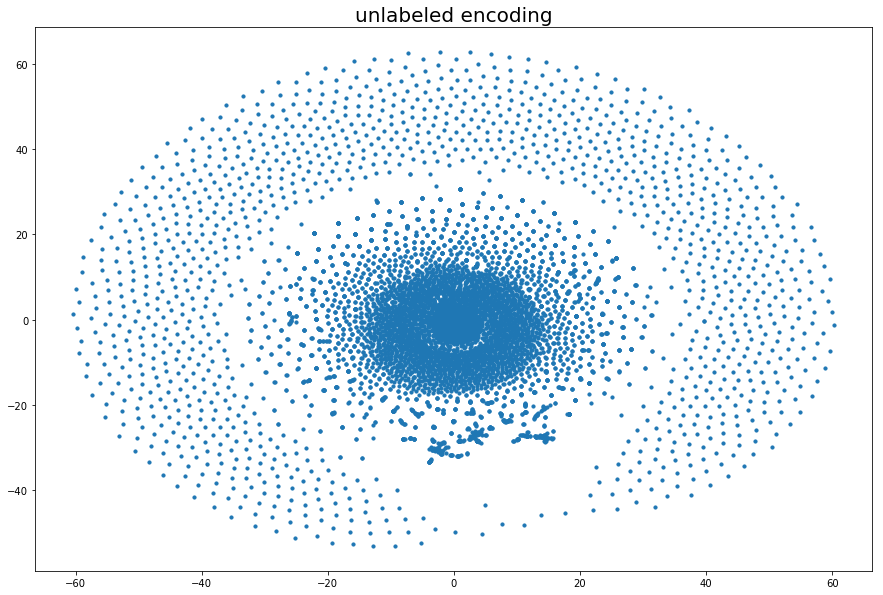

In [47]:
plot_tsne_df(tsne_df)

In [28]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [29]:
######################

In [30]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [31]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [32]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  TAC        1.200000   91.774900        14.666667  104.400000
1  QDY       -2.766667  135.463300        20.000000  149.500000
2  MMH        0.200000  133.177167        20.000000  159.666667
3  IAI        3.600000   99.131033        19.000000  140.666667
4  ERX       -4.000000  142.649850        22.500000  155.900000

In [33]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume         x0  \
0  TAC        1.200000   91.774900        14.666667  104.400000  24.810736   
1  QDY       -2.766667  135.463300        20.000000  149.500000 -12.005804   
2  MMH        0.200000  133.177167        20.000000  159.666667  -4.558371   
3  IAI        3.600000   99.131033        19.000000  140.666667 -39.276028   
4  ERX       -4.000000  142.649850        22.500000  155.900000 -12.229059   

          x1  
0 -64.155807  
1   3.343834  
2  52.005806  
3   9.878783  
4  31.783638

In [34]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

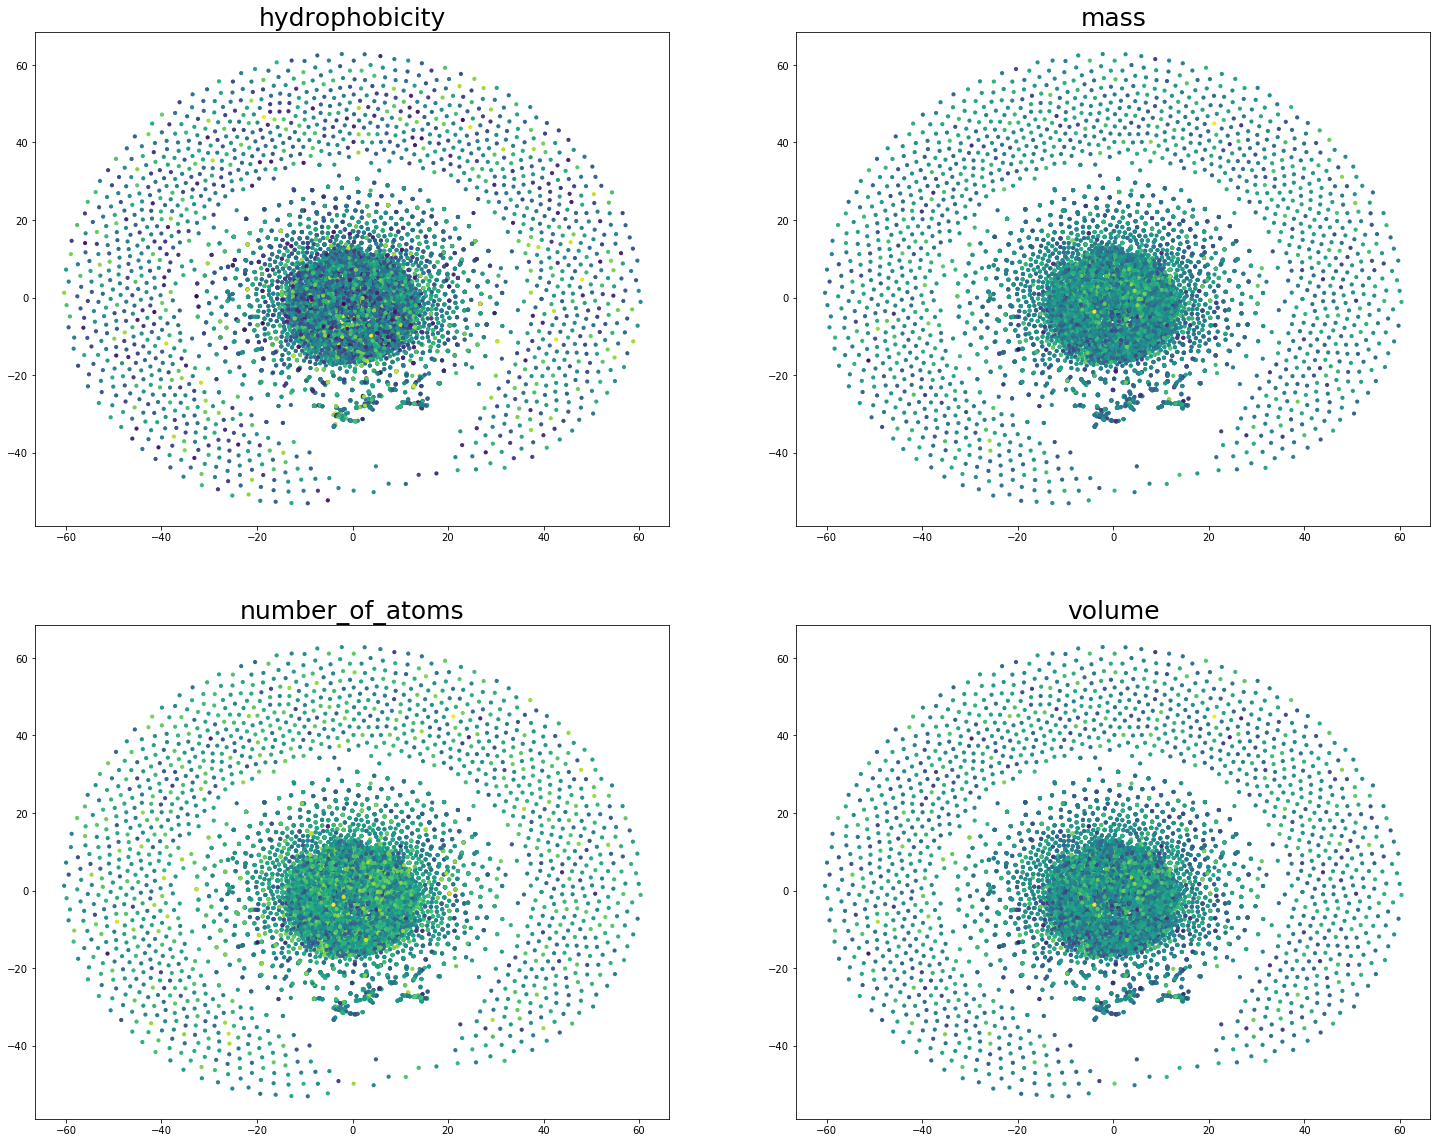

In [69]:
plot_embedding_properties(final_df)

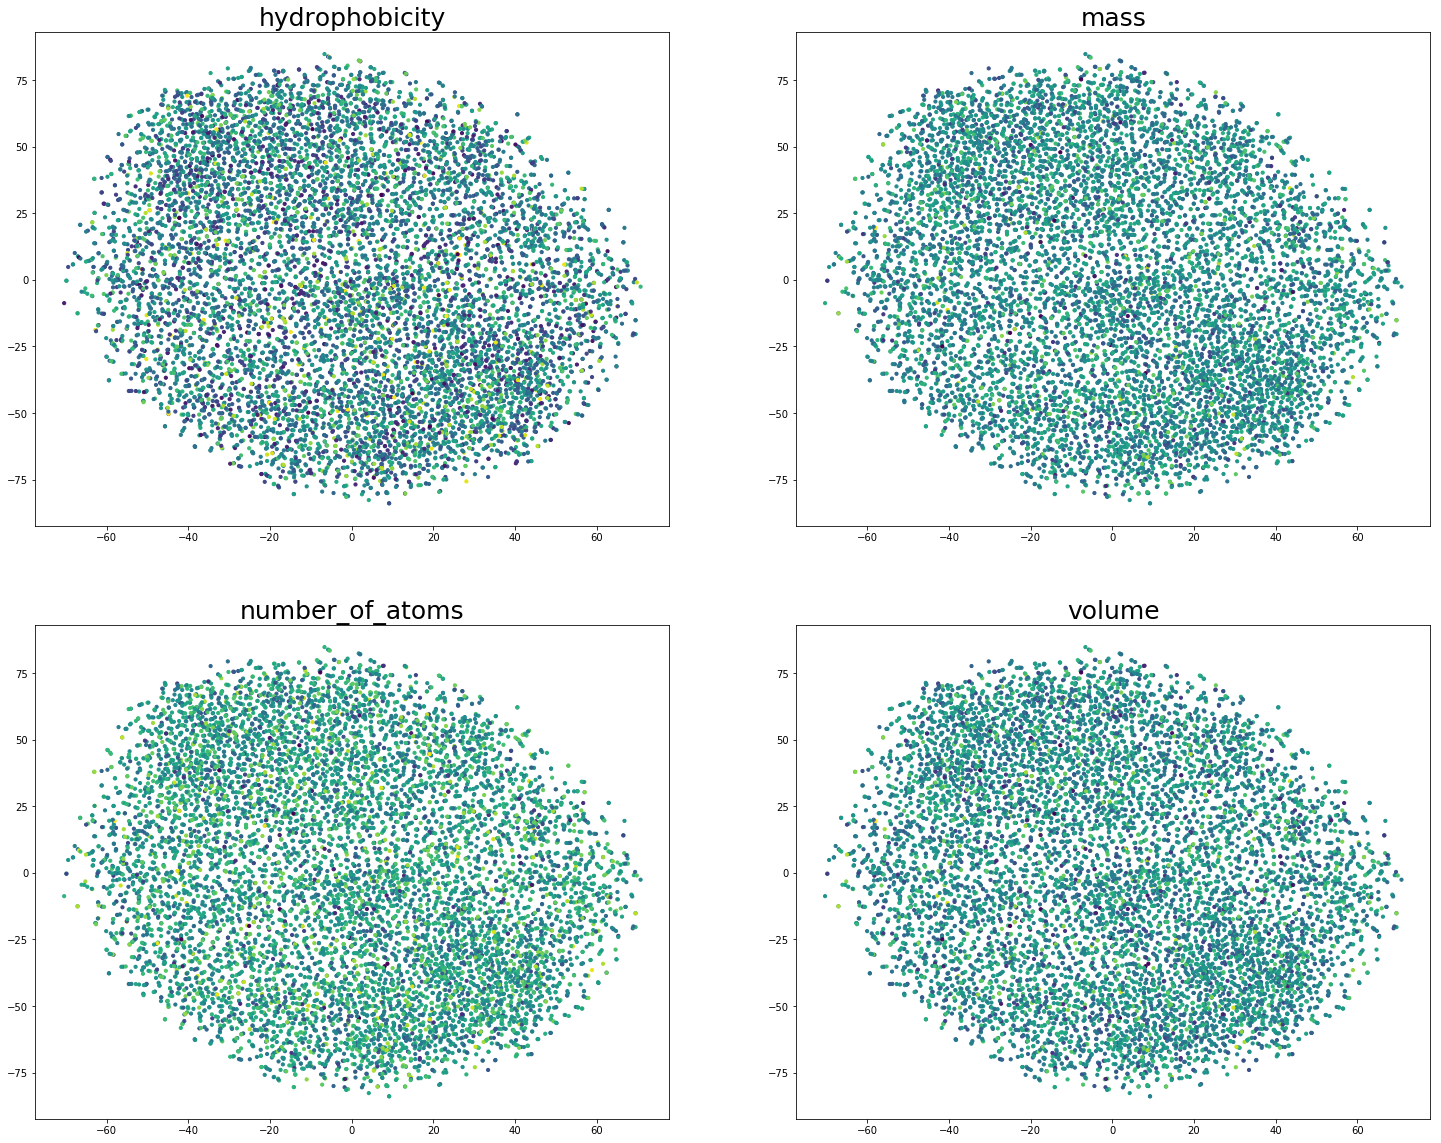

In [35]:
plot_embedding_properties(final_df)

In [70]:
######################

In [71]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

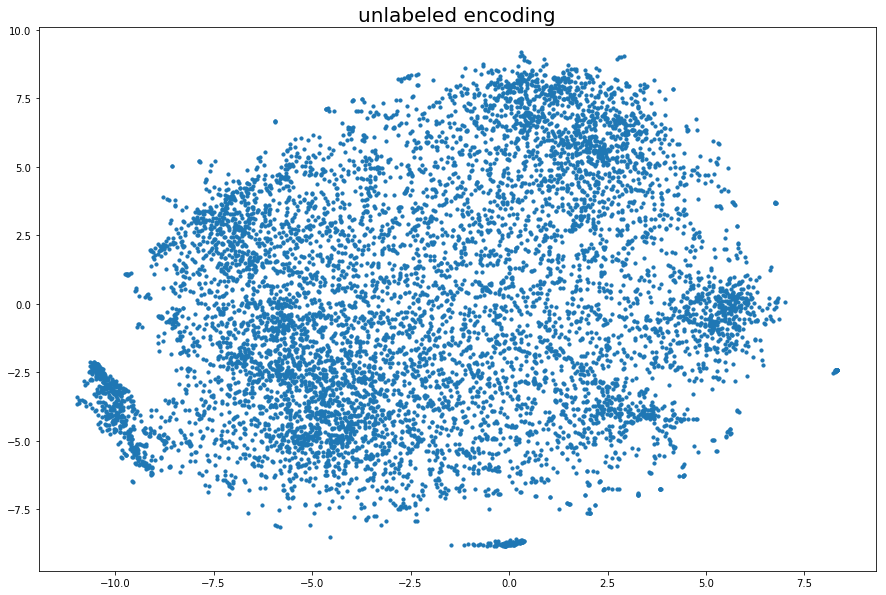

In [72]:
plot_tsne_df(gensim_tsne_df)

In [73]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

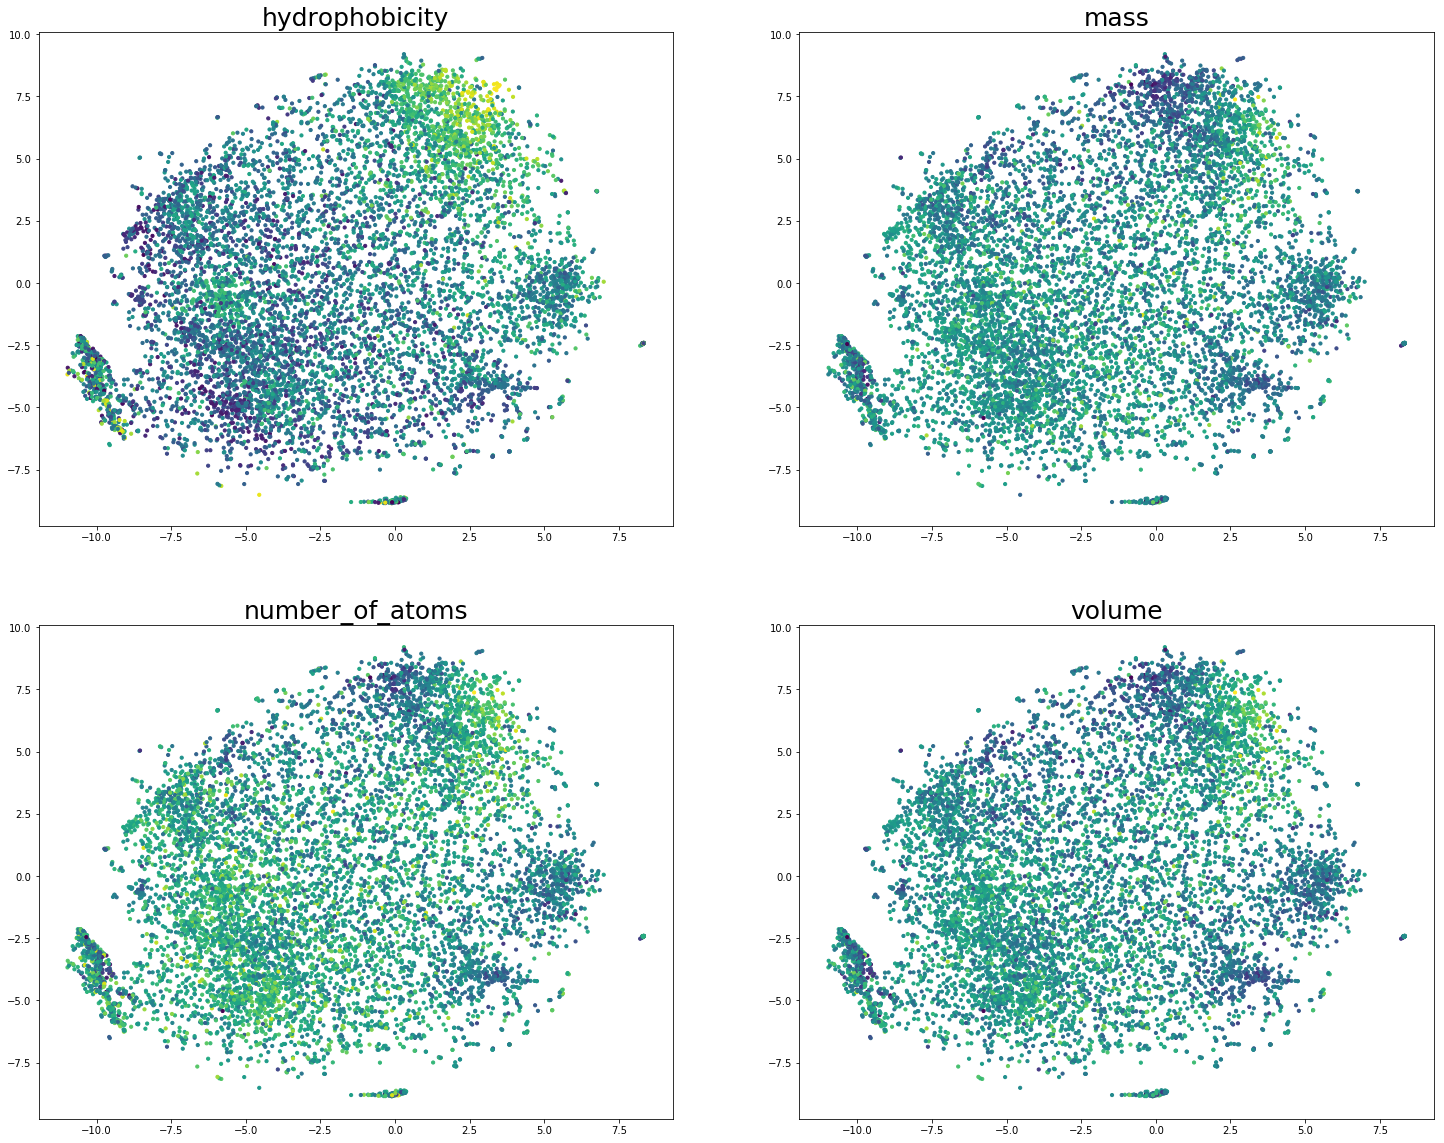

In [74]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/